Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [2]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news_ria'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [3]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [5]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.0001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  88657 - количество слов в словаре
  21068 - количество слов в словаре после фильтрации по min_tf
  20685 - количество слов в словаре после фильтрации по max_tf
  20470 - количество слов в словаре после фильтрации по min_df_rate
  20470 - количество слов в словаре после фильтрации по max_df_rate


In [6]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [7]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [8]:
params = {
    'topic_count': 15,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

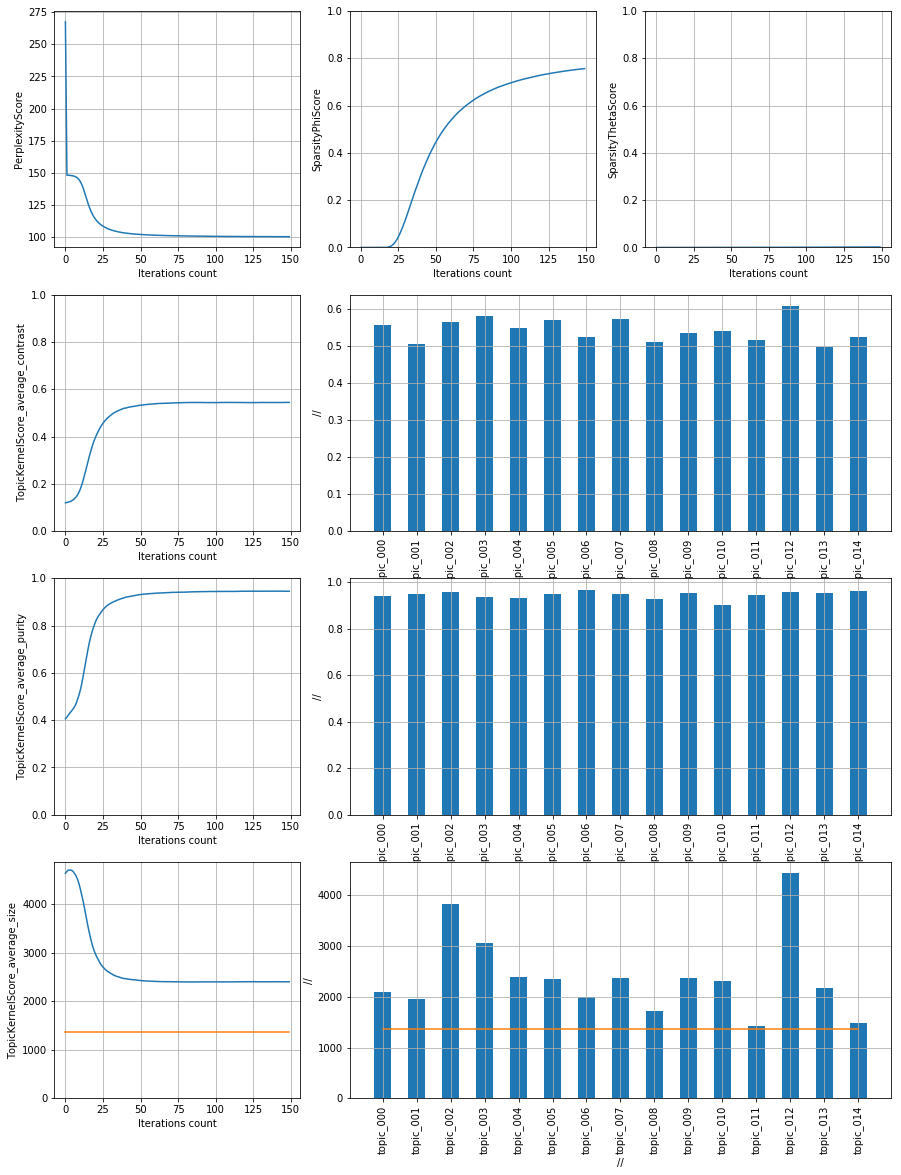

PerplexityScore: 100.07664489746094
SparsityPhiScore: 0.7567594647407532
SparsityThetaScore: 0.001847422681748867

TopicKernelScore_average_contrast: 0.544496476650238
TopicKernelScore_average_purity: 0.9453068375587463
TopicKernelScore_average_size: 2397.39990234375

TopTokensScore:
topic_000: сумма размер продажа деньги жилье услуга сеть кредит продавать долг 
topic_001: пост кандидат законопроект назначать должность голос голосование ответственность полномочие подавать 
topic_002: приходить друг жить рука помогать потом врач никто назад приходиться 
topic_003: сезон тренер спортивный минута турнир олимпийский сочи футбол играть игрок 
topic_004: франция операция иран турист ссылка нато япония сирийский телеканал египет 
topic_005: пассажир владивосток томск судно остров авиакомпания борт море рейс томский 
topic_006: нужно поэтому надо важный любой потому именно думать понимать отвечать 
topic_007: столичный квадратный парк округ построить областной станция водитель жилой метро 
top

In [9]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

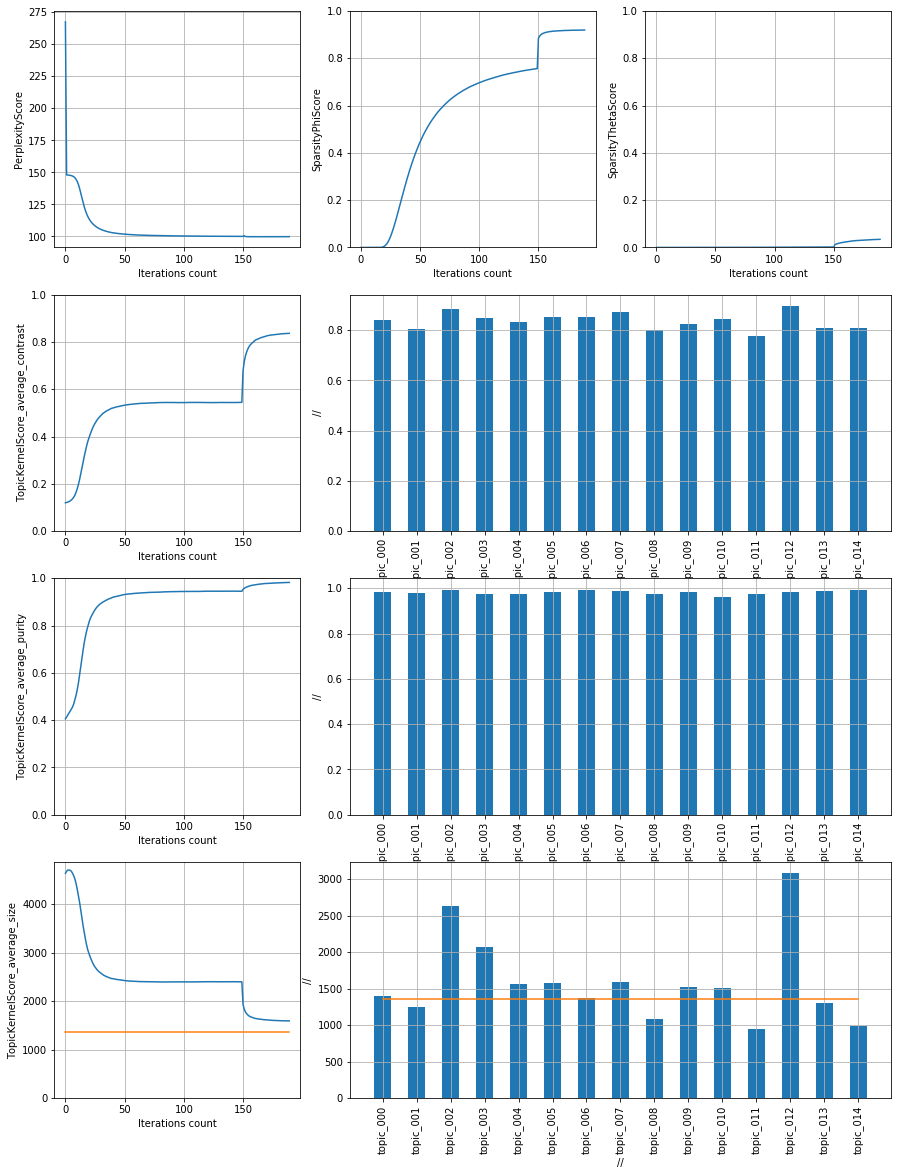

PerplexityScore: 99.86459350585938
SparsityPhiScore: 0.9198892712593079
SparsityThetaScore: 0.03430652990937233

TopicKernelScore_average_contrast: 0.836661159992218
TopicKernelScore_average_purity: 0.9826743602752686
TopicKernelScore_average_size: 1592.933349609375

TopTokensScore:
topic_000: размер сумма продажа деньги жилье услуга сеть кредит продавать долг 
topic_001: пост кандидат законопроект назначать должность законодательство голос вносить ответственность голосование 
topic_002: приходить друг назад приходиться помогать рука жить никто врач сразу 
topic_003: сезон спортивный минута тренер турнир олимпийский сочи футбол играть игрок 
topic_004: франция операция иран турист япония ссылка телеканал нато великобритания сирийский 
topic_005: пассажир владивосток томск судно море авиакомпания борт остров рейс экипаж 
topic_006: нужно поэтому любой важный потому надо отвечать именно думать понимать 
topic_007: столичный квадратный парк построить округ областной водитель станция транс

In [10]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

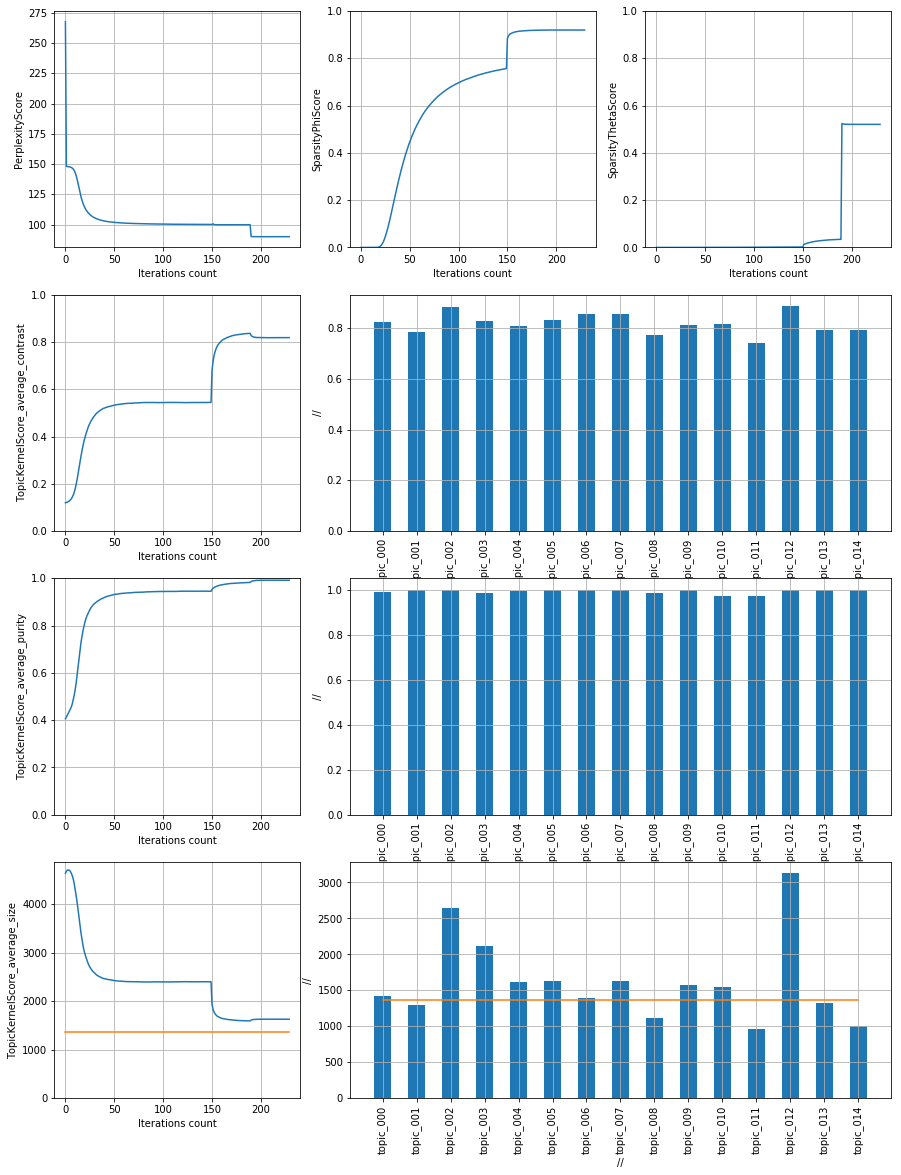

PerplexityScore: 89.98371124267578
SparsityPhiScore: 0.919970691204071
SparsityThetaScore: 0.5207394957542419

TopicKernelScore_average_contrast: 0.8184458017349243
TopicKernelScore_average_purity: 0.9919701814651489
TopicKernelScore_average_size: 1627.4000244140625

TopTokensScore:
topic_000: размер сумма продажа жилье услуга деньги кредит продавать долг капитал 
topic_001: пост кандидат законопроект должность назначать законодательство голос голосование полномочие палата 
topic_002: приходить друг рука назад жить потом уходить врач часто помогать 
topic_003: тренер спортивный сезон турнир олимпийский минута футбол сочи игрок лига 
topic_004: франция иран япония нато сирийский великобритания телеканал египет турист боевик 
topic_005: пассажир владивосток томск судно авиакомпания море борт рейс томский экипаж 
topic_006: нужно любой потому надо важный поэтому понимать думать именно внимание 
topic_007: квадратный построить водитель транспортный станция жилой столичный метро областной п

In [11]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

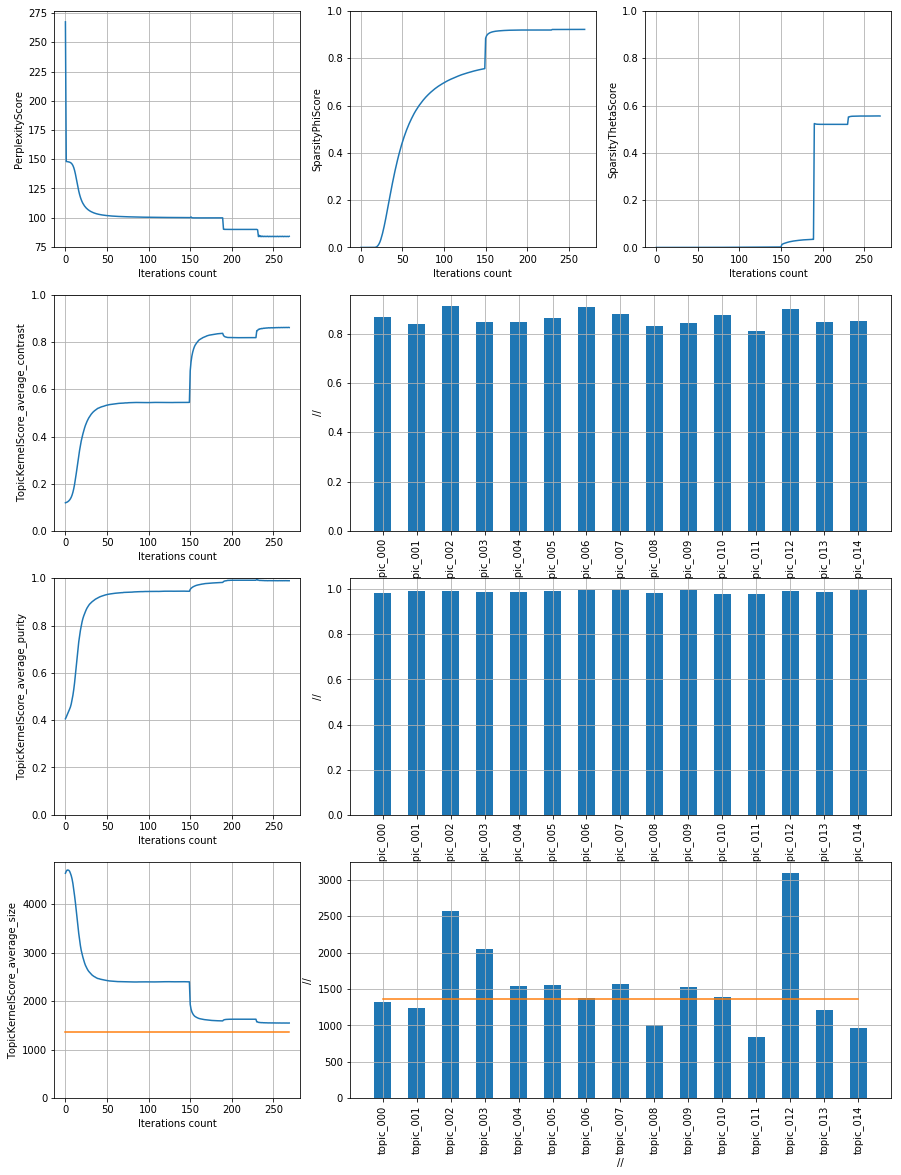

PerplexityScore: 84.1027603149414
SparsityPhiScore: 0.9225435853004456
SparsityThetaScore: 0.5561017394065857

TopicKernelScore_average_contrast: 0.8611578345298767
TopicKernelScore_average_purity: 0.9899035096168518
TopicKernelScore_average_size: 1549.5999755859375

TopTokensScore:
topic_000: деньги сумма размер продажа жилье услуга квартира торговый предоставлять кредит 
topic_001: пост кандидат законопроект михаил назначать палата утверждать должность требовать судебный 
topic_002: друг приходиться попадать мало взять приходить несмотря жить врач назад 
topic_003: тренер спортивный сезон турнир минута олимпийский этап футбол сочи игрок 
topic_004: операция франция китай великобритания турист вооруженный иран япония ссылка нато 
topic_005: пассажир владивосток сильный томск судно ожидаться остров авиакомпания море борт 
topic_006: поэтому нужно позиция задача многий заниматься любой именно отвечать потому 
topic_007: станция округ авария машина квадратный парк столичный построить обл

In [12]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

In [13]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,topic_010,topic_011,topic_012,topic_013,topic_014
карастелев,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000028,0.000000,0.000000,0.000000,0.000000,0.0
гиббс,0.000000,0.000000,0.000000,0.000000,0.000052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
холбрук,0.000000,0.000000,0.000000,0.000000,0.000230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
тенге,0.000245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
некляев,0.000000,0.000131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
змий,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000027,0.000000,0.0
летальность,0.000000,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
кровоточивость,0.000000,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
геморрагия,0.000000,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
касабланка,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.0


In [14]:
theta = model_artm.get_theta()
theta

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,21990,21991,21992,21993,21994,21995,21996,21997,21998,21999
topic_000,0.099174,0.009611,0.001578,0.004822,1.229014e-03,0.020141,0.007301,0.066739,0.169735,0.021965,...,0.031426,0.137867,0.015783,0.011783,0.003076,0.116494,0.307560,0.027803,0.067179,0.227389
topic_001,0.234797,0.006289,0.000586,0.004043,5.737840e-09,0.249543,0.071708,0.110522,0.033676,0.038718,...,0.015588,0.091044,0.053448,0.010255,0.025761,0.065197,0.016522,0.104752,0.018010,0.051661
topic_002,0.026286,0.335684,0.044635,0.015395,5.247281e-03,0.032441,0.028790,0.006756,0.086509,0.033067,...,0.009928,0.042153,0.029005,0.003555,0.008091,0.027971,0.014366,0.003150,0.233671,0.105497
topic_003,0.348419,0.006338,0.019982,0.000392,4.340159e-03,0.007416,0.018151,0.012986,0.065003,0.071783,...,0.041576,0.013238,0.048244,0.015723,0.004294,0.003818,0.048487,0.466808,0.013789,0.005887
topic_004,0.041803,0.010566,0.018594,0.050433,4.260377e-01,0.123346,0.338861,0.020439,0.019233,0.172699,...,0.083600,0.030898,0.086075,0.017105,0.137651,0.019922,0.022735,0.041463,0.014705,0.013107
topic_005,0.009258,0.013844,0.099281,0.170457,3.438435e-01,0.077217,0.012553,0.040931,0.003331,0.022861,...,0.011512,0.020226,0.045452,0.568731,0.019294,0.040588,0.004721,0.009572,0.036864,0.046365
topic_006,0.081550,0.047869,0.005146,0.001243,6.576144e-03,0.004596,0.044769,0.047413,0.071520,0.200151,...,0.048380,0.077124,0.018758,0.022528,0.301078,0.061872,0.031006,0.001071,0.017425,0.032193
topic_007,0.004043,0.011231,0.592998,0.057015,1.076434e-01,0.020399,0.022114,0.101754,0.004858,0.001557,...,0.006601,0.015406,0.039505,0.180929,0.005783,0.021934,0.024124,0.000573,0.061819,0.159553
topic_008,0.020548,0.014598,0.018200,0.089744,2.929555e-02,0.182305,0.097953,0.088242,0.160863,0.085842,...,0.034035,0.032783,0.123534,0.039572,0.047470,0.104072,0.153366,0.013719,0.020432,0.021368
topic_009,0.017731,0.032365,0.157813,0.529467,1.164086e-02,0.059007,0.054211,0.099842,0.038947,0.013189,...,0.011440,0.179717,0.025271,0.014977,0.085139,0.018938,0.005820,0.007719,0.295937,0.008725
